In [76]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

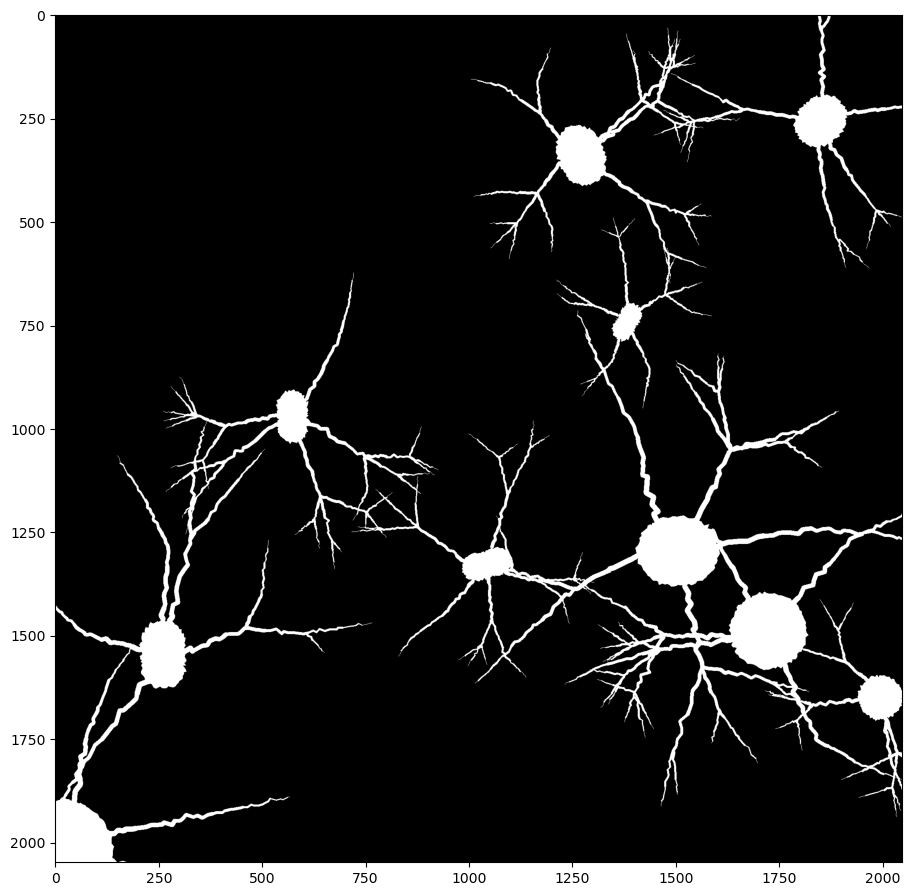

In [140]:
class Soma:
    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (np.cos(theta) * np.cos(elongation_angle) - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (np.sin(theta) * np.cos(elongation_angle) + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio) + self.position[1]
        
        return x_soma, y_soma

    def draw(self, color):
        plt.fill(self.x_soma, self.y_soma, color=color)
        
    def create_binary_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.int32)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)
        cv2.fillPoly(mask, [coordinates], 1)
        return mask

class Dendrite:
    def __init__(self, soma, depth, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.dendrite_list = []  

        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(0.8, 1.2)
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r**i for i in range(self.depth))
        
        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r**i
        
        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(int)

        random_offsets = np.random.randint(-num_soma_points // (100 // self.n_primary_dendrites // 1.5), 
                                           (100 // self.n_primary_dendrites // 1.5) + 1, 
                                           size=self.n_primary_dendrites)
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = .02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        # Calculate proportions
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)
        
        # Ensure proportions are within [0, 1]
        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)
        
        # Calculate thicknesses
        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)
        
        # Ensure thicknesses are at least 1
        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)
        
        return thickness_at_start, thickness_at_end


        
    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = int(self.curviness_magnitude * 10)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)
        
        if self.curviness == 'Gauss':
            perturb_xs = xs + (length // 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length // 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length // 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys
            
        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2
        
        return perturb_xs, perturb_ys

    def _grow_branch(self, x, y, angle, remaining_depth):
        if remaining_depth == 0:
            return []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        #sum_length = sum(self.branch_lengths[:len(self.branch_lengths) - self.depth+1])
        # Calculate the cumulative path length from the soma up to the current depth
        sum_length = sum(self.branch_lengths[:self.depth - remaining_depth])

        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)
        
        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)
        
        end_x = x + branch_length * np.cos(angle)
        end_y = y + branch_length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, branch_length)
        
        self.dendrite_list.append([np.array([weave_x, weave_y]), branch_length, self.depth - remaining_depth, thickness_start, thickness_end])

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            new_branches.append(((end_x, end_y), new_angle))

        return new_branches

    def draw(self, color):
        for branch in self.dendrite_list:
            points = branch[0]
            thickness_start = branch[3]
            thickness_end = branch[4]
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))


            for i in range(len(points[0]) - 1):
                plt.plot(points[0][i:i+2], points[1][i:i+2], color=color, linewidth=thicknesses[i])

    def create_dendrite_mask(self, size=(2048, 2048)):
        mask = np.zeros(size, dtype=np.uint8)

        for branch in self.dendrite_list:
            points = branch[0]
            thickness_start = branch[3]
            thickness_end = branch[4]
            thicknesses = np.linspace(thickness_start, thickness_end, len(points[0]))
            # Round thicknesses and ensure they are at least 1
            thicknesses = np.clip(np.round(thicknesses), 1, None).astype(int)
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            for i in range(len(coordinates) - 1):
                cv2.line(mask, tuple(coordinates[i]), tuple(coordinates[i + 1]), 1, thickness=thicknesses[i])

        return mask
class Neuron:
    def __init__(self, position, depth, mean_soma_radius, std_soma_radius, D, branch_angle, mean_branches, weave_type=None, randomness=0.0, 
                 curviness=None, curviness_magnitude=1.0, n_primary_dendrites=4, network=None, neuron_id = None):
        
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.soma_mask = Soma.create_binary_mask(self.soma)
        self.dendrite = Dendrite(self.soma, depth, D, branch_angle, mean_branches, weave_type, randomness, curviness, curviness_magnitude, n_primary_dendrites)
        self.dendrite_mask = np.zeros((network.width, network.height), dtype=np.uint8)
        self.mask = None
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.start_points = None
        self.branch_ends = []

    def generate_start_points(self):
        self.start_points = self.dendrite._generate_dendrite_start_points()
        self.branch_ends = [(point, np.arctan2(point[1] - self.position[1], point[0] - self.position[0])) for point in self.start_points]

    def grow_layer(self):
        """
        Grow the neuron's dendrites by one layer, checking for overlaps and updating the dendrite mask.
        """
        if self.current_depth >= self.dendrite.depth:
            return False

        new_branch_ends = []
        collision_detected = False  # Track if any collision is detected

        for start_point, angle in self.branch_ends:
            branches = self.dendrite._grow_branch(start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth)

            for (end_x, end_y), new_angle in branches:
                # Create a temporary mask to check collision
                temp_dendrite_mask = np.copy(self.dendrite_mask)
                cv2.line(temp_dendrite_mask, (int(start_point[0]), int(start_point[1])), (int(end_x), int(end_y)), 1, thickness=1)

                # Check for collision with other somas
                overlap = np.logical_and(self.network.somas_mask - self.soma_mask, temp_dendrite_mask)

                if not np.any(overlap):
                    # If no collision, update the actual mask and add the new branch end
                    cv2.line(self.dendrite_mask, (int(start_point[0]), int(start_point[1])), (int(end_x), int(end_y)), 1, thickness=1)
                    new_branch_ends.append(((end_x, end_y), new_angle))
                else:
                    # If collision detected, mark the collision
                    collision_detected = True

        self.branch_ends = new_branch_ends
        self.current_depth += 1

        # If any branch grows, return True; if all collided, return False
        return not collision_detected and bool(new_branch_ends)


    
    def draw(self, color):
        self.soma.draw(color)
        self.dendrite.draw(color)

    def connect_branches(self, other_neuron=None, connection_threshold=5.0):
        """
        Connects branches within the same neuron or between this neuron and another neuron
        based on binary mask overlap.
        """
        # Use the existing dendrite mask for the current neuron
        self_dendrite_mask = self.dendrite_mask

        if other_neuron is None:
            # Self-connections: check for overlap of each branch with the rest of the dendrites
            for i, branch1 in enumerate(self.dendrite.dendrite_list):
                # Create a temporary mask for the current branch
                branch_mask = np.zeros_like(self_dendrite_mask)
                points = branch1[0]
                coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
                for k in range(len(coordinates) - 1):
                    cv2.line(branch_mask, tuple(coordinates[k]), tuple(coordinates[k + 1]), 1, thickness=1)
                
                # Exclude the current branch mask from the overall dendrite mask
                remaining_mask = np.logical_and(self_dendrite_mask, np.logical_not(branch_mask)).astype(np.uint8)

                # Check for overlap between the current branch mask and the rest of the dendrites
                overlap = np.logical_and(remaining_mask, branch_mask)
                if np.any(overlap):
                    # If there is an overlap, stop the shorter branch from growing
                    for j, branch2 in enumerate(self.dendrite.dendrite_list):
                        if i != j and branch1[2] != 0 and branch2[2] != 0:
                            if branch1[1] < branch2[1]:
                                branch1[2] = 0
                            else:
                                branch2[2] = 0
        else:
            # Between different neurons: use the other neuron's dendrite mask
            other_dendrite_mask = other_neuron.dendrite_mask

            # Check for overlap between the current dendrite mask and the other neuron's dendrite mask
            overlap = np.logical_and(self_dendrite_mask, other_dendrite_mask)
            if np.any(overlap):
                # Loop through branches and stop the shorter branch from growing
                for branch1 in self.dendrite.dendrite_list:
                    for branch2 in other_neuron.dendrite.dendrite_list:
                        if branch1[2] != 0 and branch2[2] != 0:
                            if branch1[1] < branch2[1]:
                                branch1[2] = 0
                            else:
                                branch2[2] = 0


    
    def generate_binary_mask(self):
        soma_mask = self.soma_mask
        dendrite_mask = self.dendrite.create_dendrite_mask()
        self.neuron_mask = np.logical_or(soma_mask, dendrite_mask).astype(np.uint8) 
        return self.neuron_mask

class Network:
    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.width, self.height), dtype=np.uint16)
        self.somas_mask = np.zeros((self.width, self.height), dtype=np.int32)
        self.network_id = network_id

    def _seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100  # Limit the number of attempts to avoid infinite loops
            attempts = 0

            while attempts < max_attempts:
                # Generate a random position for the neuron
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_{neuron_index}"

                # Create a new neuron object
                neuron = Neuron(position, **self.neuron_params, network=self, neuron_id=neuron_id)

                # Create a binary mask of the soma
                new_soma_mask = neuron.soma.create_binary_mask()

                # Check if there is an overlap with any existing somas
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # If there is no overlap, add the neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break  # Exit the while loop and move to the next neuron

                attempts += 1

            if attempts == max_attempts:
                print(f"Warning: Could not place neuron {neuron_index} without overlap after {max_attempts} attempts.")


    def grow_network(self):
        growing = True
        while growing:
            growing = False
            for neuron in self.neurons:
                if neuron.grow_layer():
                    growing = True
            self._simulate_connections()
            #network.draw()

    def _simulate_connections(self):
        for i, neuron in enumerate(self.neurons):
            for j in range(i + 1, len(self.neurons)):
                neuron.connect_branches(self.neurons[j])

    def generate_binary_mask(self):
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        for neuron in self.neurons:
            neuron_mask = neuron.generate_binary_mask()
            self.network_mask = np.logical_or(self.network_mask, neuron_mask).astype(np.uint8)
        return self.network_mask

    def draw(self):
        plt.figure(figsize=(12, 12))
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.gca().set_xticklabels([])
        plt.gca().set_yticklabels([])        
    
        for neuron in self.neurons:
            color = np.random.rand(3,)
            neuron.draw(color=color)
            
        plt.axis('equal')
        plt.xlim(0, self.width)
        plt.ylim(0, self.height)
        plt.show()

    def create_dataframe(self):
        data = {
            f'{self.network_id}_network_mask': [self.network_mask]
        }
        for neuron in self.neurons:
            data[neuron.neuron_id] = [neuron.neuron_mask]

        df = pd.DataFrame.from_dict(data, orient='columns')
        return df

# Parameters
network_width = 2048
network_height = 2048
num_neurons = 10

# Neuron-specific parameters with Gaussian distribution
neuron_params = {
    'depth': 3,
    'mean_soma_radius': 60,
    'std_soma_radius': 15,
    'D': 1.5,
    'branch_angle': np.pi / 4,
    'mean_branches': 1.5,
    'weave_type': 'Gauss',
    'randomness': 0.2,
    'curviness': 'Gauss',
    'curviness_magnitude': 1.5,
    'n_primary_dendrites': 5
}

# Create and generate the network
network = Network(network_width, network_height, num_neurons, neuron_params,'nn0')
network._seed_neurons()
network.grow_network()

# Draw the network
#network.draw()

network_mask = network.generate_binary_mask()
network_mask_flipped = np.flipud(network_mask)
plt.figure(figsize=(11,11))
plt.imshow(network_mask_flipped, cmap='gray')
plt.show()

nn0_df = network.create_dataframe()
#print(nn0_df) 

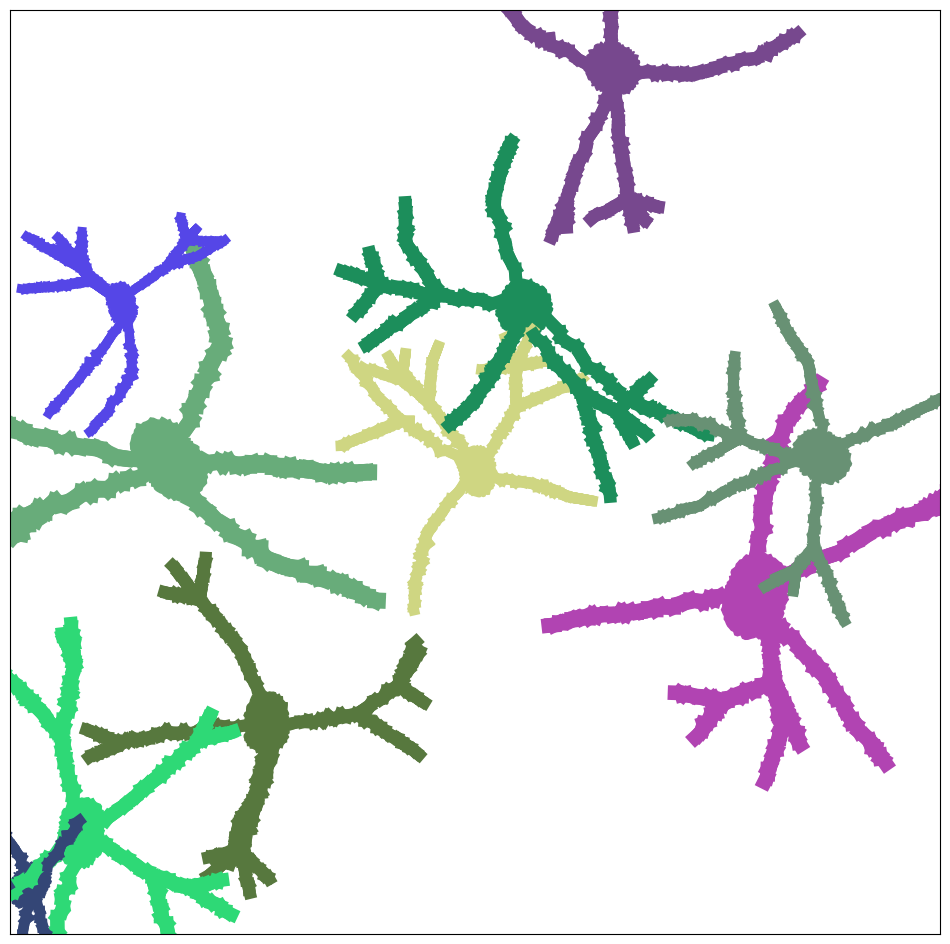

In [137]:
network.draw()

124186
123945
-241


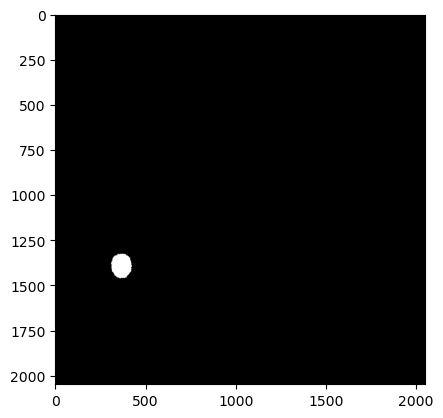

In [100]:
test = np.logical_and(network.somas_mask, np.logical_not(network.neurons[0].soma_mask)).astype(np.int32)
test = network.somas_mask - network.neurons[0].soma_mask
plt.imshow(np.flipud(test), cmap='gray')
plt.imshow(network.neurons[0].soma_mask, cmap = 'gray')
network.somas_mask

np.clip(network.somas_mask, 0,1)


total_sum = 0

for neuron in network.neurons:
    np.clip(neuron.soma_mask, 0,1)
    total_sum += np.sum(neuron.soma_mask)
    

print(total_sum)
print(np.sum(network.somas_mask))
print(np.sum(network.somas_mask) - total_sum)

#figure out why second test method doesn't work

In [9]:
def batch_generate_networks(
    num_networks, 
    output_dir, 
    network_prefix='network_', 
    network_width=2048, 
    network_height=2048, 
    num_neurons=20, 
    neuron_params=None,
    save_plt = False
):
    """
    Generates multiple networks and saves their images and binary masks to a directory.
    
    :param num_networks: Number of networks to generate.
    :param output_dir: Directory where output files will be saved.
    :param network_prefix: Prefix for network filenames.
    :param network_width: Width of the network (default 2048).
    :param network_height: Height of the network (default 2048).
    :param num_neurons: Number of neurons in each network (default 20).
    :param neuron_params: Dictionary of parameters for neuron generation.
    """
    if neuron_params is None:
        neuron_params = {
            'depth': 4,
            'mean_soma_radius': 60,
            'std_soma_radius': 15,
            'D': 1.2,
            'branch_angle': np.pi / 4,
            'mean_branches': 1.5,
            'weave_type': 'Gauss',
            'randomness': 0.3,
            'curviness': 'Gauss',
            'curviness_magnitude': 1,
            'n_primary_dendrites': 5
        }
    
    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    
    # Create subdirectory for pandas DataFrames
    df_output_dir = os.path.join(output_dir, 'dataframes')
    os.makedirs(df_output_dir, exist_ok=True)

    for i in range(num_networks):
        network_id = f'{network_prefix}{i}'
        print(f"Generating network {network_id}...")

        # Create and generate the network
        network = Network(network_width, network_height, num_neurons, neuron_params, network_id)
        network._seed_neurons()
        network.grow_network()

        # Save the network image
        if save_plt:
            image_path = os.path.join(output_dir, f'{network_id}.png')
            network.draw()
            plt.savefig(image_path)
            plt.close()

        # Save the binary mask
        mask = network.generate_binary_mask()
        mask_path = os.path.join(output_dir, f'{network_id}_mask.png')
        plt.imsave(mask_path, np.flipud(mask), cmap='gray')

        # Save the network data as a DataFrame in a subdirectory
        df = network.create_dataframe()
        csv_path = os.path.join(df_output_dir, f'{network_id}.csv')
        df.to_csv(csv_path, index=False)

        if save_plt:
            print(f"Network {network_id} saved: {image_path}, {mask_path}, {csv_path}")
        else:
            print(f"Network {network_id} saved: {mask_path}, {csv_path}")

# Example usage
output_directory = r"C:\Users\absolute-zero\Desktop\nn_is\networks"
number_of_networks = 5
network_prefix = 'test_network_'  # You can change this prefix as needed

batch_generate_networks(num_networks=number_of_networks, output_dir=output_directory, network_prefix=network_prefix)


Generating network test_network_0...
Network test_network_0 saved: C:\Users\absolute-zero\Desktop\nn_is\networks\test_network_0_mask.png, C:\Users\absolute-zero\Desktop\nn_is\networks\dataframes\test_network_0.csv
Generating network test_network_1...
Network test_network_1 saved: C:\Users\absolute-zero\Desktop\nn_is\networks\test_network_1_mask.png, C:\Users\absolute-zero\Desktop\nn_is\networks\dataframes\test_network_1.csv
Generating network test_network_2...
Network test_network_2 saved: C:\Users\absolute-zero\Desktop\nn_is\networks\test_network_2_mask.png, C:\Users\absolute-zero\Desktop\nn_is\networks\dataframes\test_network_2.csv
Generating network test_network_3...
Network test_network_3 saved: C:\Users\absolute-zero\Desktop\nn_is\networks\test_network_3_mask.png, C:\Users\absolute-zero\Desktop\nn_is\networks\dataframes\test_network_3.csv
Generating network test_network_4...
Network test_network_4 saved: C:\Users\absolute-zero\Desktop\nn_is\networks\test_network_4_mask.png, C:\Use